# Installing the relevant libraries

In [ ]:
pip install langchain pypdfium2 tqdm seaborn spacy nltk mlflow  accelerate bitsandbytes xformers einops pyngrok evaluate rouge_score

In [ ]:
pip install transformers==4.30

In [ ]:
!pip install -qU pinecone-client==2.2.4

In [ ]:
pip install -U sentence-transformers

# Loading the relevant libraries

In [ ]:
#Importing the relevant libraries

# Document Loaders
from langchain.document_loaders.pdf import PyPDFium2Loader
from langchain.document_loaders import DirectoryLoader

# Document Splitter
from langchain.text_splitter import RecursiveCharacterTextSplitter,SpacyTextSplitter,NLTKTextSplitter

# tqdm for tracking time
from tqdm import tqdm
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Hashing
import hashlib

# Torch and transformers
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline,AutoModelForSeq2SeqLM

# Models
from langchain.llms import HuggingFacePipeline
from langchain.embeddings import HuggingFaceInstructEmbeddings,SentenceTransformerEmbeddings

# Vector Store
from langchain.vectorstores import Pinecone
import pinecone

# Prompts
from langchain import PromptTemplate, LLMChain

# Retrievers
from langchain.chains import RetrievalQA

# Importing time and textwrap
import textwrap
import time
from datetime import datetime

# Mounting and extracting pdfs
import zipfile
from google.colab import drive
import os

#nltk
import nltk
nltk.download('punkt')

import locale
locale.getpreferredencoding = lambda: "UTF-8"

#mlflow tracking
import mlflow
import nltk.translate.bleu_score as bleu
import re

#evaluation
import evaluate

#semantic similarity
from sentence_transformers import SentenceTransformer, util

#torch and gc
import gc

from pyngrok import ngrok

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Displaying the entire column in a dataframe
pd.set_option('display.max_colwidth', None)

# Loading the pdf documents

In [ ]:
#Function for loading pdfs

def pdf_load_extract(pdf_loader,pdf_path,progress_display=True,multi_thread=False):

  drive.mount('/content/drive/')

  loader = DirectoryLoader(pdf_path,
                         glob="**/*.pdf",
                         use_multithreading=multi_thread,
                         show_progress=progress_display,
                         loader_cls=pdf_loader)
  docs = loader.load()

  return docs

In [ ]:
#Loading pdf documents
path = '/content/drive/My Drive/Gen AI Case Study/PDF Documents/'
loader = PyPDFium2Loader

doc_start_time = datetime.now()
pdf_documents = pdf_load_extract(loader,path)
doc_end_time = datetime.now()

print('Time elapsed (hh:mm:ss.ms) {}'.format(doc_end_time - doc_start_time))

Mounted at /content/drive/


  0%|          | 0/87 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/pypdfium2/_helpers/textpage.py:81: UserWarning: get_text_range() call with default params will be implicitly redirected to get_text_bounded()
  warnings.warn("get_text_range() call with default params will be implicitly redirected to get_text_bounded()")
100%|██████████| 87/87 [03:03<00:00,  2.10s/it]

Time elapsed (hh:mm:ss.ms) 0:03:38.813909


# Extracting Additonal Metadata (In addition to the page number)


*   Filename
*   Set
*   Category



In [ ]:
# Function for extracting metadata
def metadata_extraction(docs):

  metadata_list = []

  for i in range(len(docs)):
    #Adding the filename
    docs[i].metadata['filename'] = docs[i].metadata['source'].split("/")[-1]
    #Adding the Set
    docs[i].metadata['set'] = docs[i].metadata['source'].split("/")[-2]
    #Adding the category for set 1
    if docs[i].metadata['set'] == 'Set1':
      docs[i].metadata['category'] = docs[i].metadata['filename'].split("_")[2]
    else:
      docs[i].metadata['category'] = 'NA'
    #Adding the charcter count
    docs[i].metadata['charcount'] = len(docs[i].page_content)
    metadata_list.append(docs[i].metadata)

  return metadata_list




In [ ]:
# Extracting metadata as a dataframe
docs = pdf_documents
metadata_df = pd.DataFrame(metadata_extraction(docs))
print(metadata_df.shape)

(2547, 6)


# EDA on the Pdf Documents

* Average number of pages
* Missing documents or documents that could not be parsed
* Page count distributions
* Character count distributions
* Token count distributions

In [ ]:
#avg pages across set 1 & set 2 files (87 pdfs)
total_pages_by_file = metadata_df.groupby(["set","filename"]).agg({"page":"count"}).reset_index()
# total_pages_by_file["page"].sum()/total_pages_by_file.shape[0]
total_pages_by_file.groupby(["set"]).agg({'page':"mean"})

,page
set,
Set1,11.351351
Set2,42.540000


In [ ]:
# Any documents missing while reading?
set_a = set(os.listdir(path+ 'Set1/') + os.listdir(path+ 'Set2/'))
set_b = set(total_pages_by_file["filename"].tolist())
set_a - set_b

set()

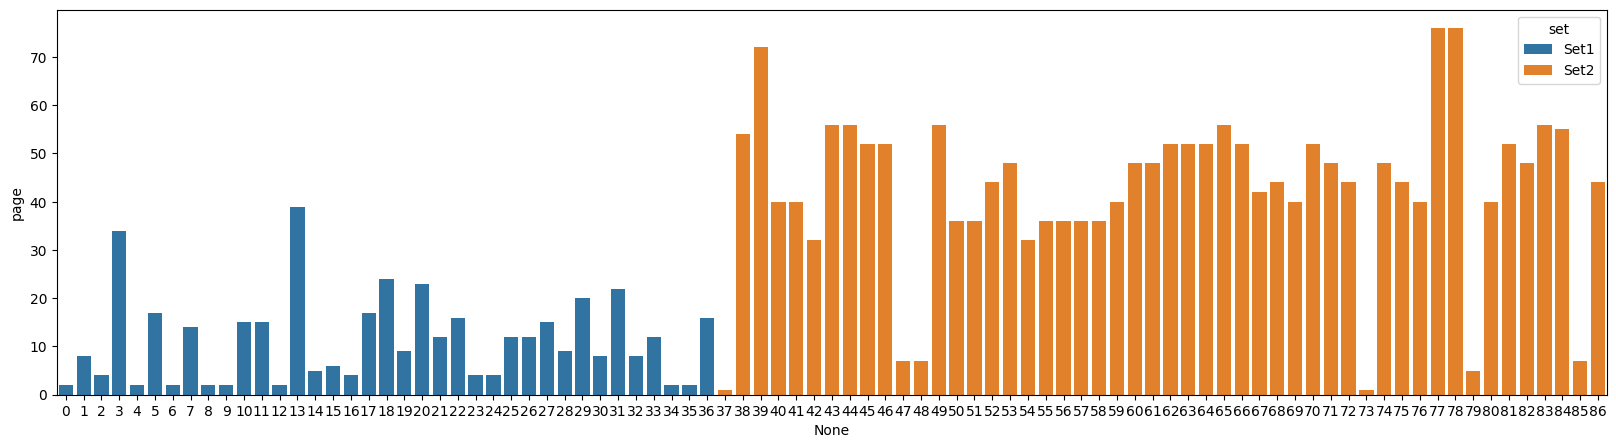

In [ ]:
#Page counts across set 1 and set 2 files
plt.figure(figsize=(20,5))
plt.xticks(rotation=0)
ax = sns.barplot(total_pages_by_file,
            x=total_pages_by_file.index,
            y=total_pages_by_file["page"],
            hue=total_pages_by_file["set"])


In [ ]:
#Distribution of files by #pages

def annotate_bars(ax=None, fmt='.2f', **kwargs):
    ax = plt.gca() if ax is None else ax
    for p in ax.patches:
         ax.annotate('{{:{:s}}}'.format(fmt).format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                     xytext=(0, 5),textcoords='offset points',
                     ha='center', va='center', **kwargs)


def dist_plot(annotate_bars,data,groupby_col,agg_col):

    g = sns.displot(data, x=agg_col, hue='set',kde=True)
    g.map(annotate_bars, fmt='.2g', fontsize=8, color='k')
    g.fig.set_size_inches(7,4)


    x1,x2 = data.groupby(groupby_col).agg({agg_col:"mean"}).values

    g.axes[0, 0].axvline(x1, color='blue', lw=2)
    g.axes[0, 0].axvline(x2, color='orange', lw=2)

    g.axes[0, 0].text(x1,20,x1,color='blue')
    g.axes[0, 0].text(x2,20,x2,color='orange')

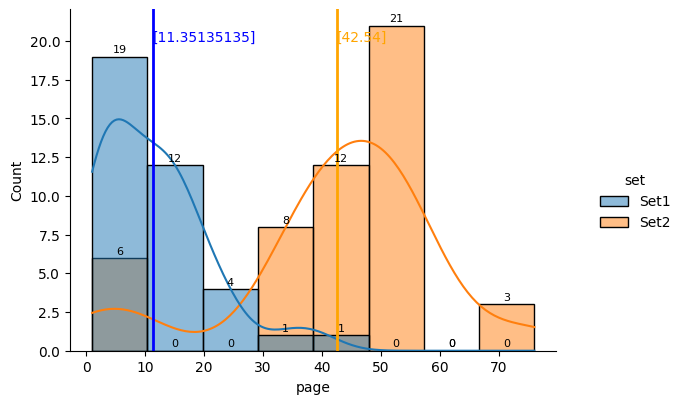

In [ ]:
dist_plot(annotate_bars,total_pages_by_file,"set","page")

In [ ]:
#Average Characters and tokens by file df
char_by_file = metadata_df.groupby(["set","filename"]).agg({"charcount":"sum","page":"count"}).reset_index()

In [ ]:
#Files that could not be parsed
print(char_by_file[char_by_file["charcount"]<1000])
files_not_parsed = char_by_file[char_by_file["charcount"]<1000]["filename"].tolist()

     set                                             filename  charcount  page
0   Set1      Black_Decker_AirCompresssor_ID_4700_Scanned.pdf          2     2
1   Set1  Black_Decker_AirCompresssor_ID_WX-RP810_Scanned.pdf        456     8
28  Set1           Black_Decker_LawnMower_ID_8000_Scanned.pdf          9     9
30  Set1              Black_Decker_LawnMower_Nil2_Scanned.pdf          8     8
32  Set1                Black_Decker_Trimmer_Nil1_Scanned.pdf          8     8
33  Set1                Black_Decker_Trimmer_Nil2_Scanned.pdf         12    12
34  Set1          Black_Decker_VacuumCleaner_Nil1_Scanned.pdf          2     2
35  Set1          Black_Decker_VacuumCleaner_Nil4_Scanned.pdf          2     2


In [ ]:
#Removing the files that could not be parsed and checking the average #pages, #characters, #tokens
char_by_file_reduced = char_by_file[~char_by_file["filename"].isin(files_not_parsed)]
char_by_file_reduced["tokencount"] = char_by_file_reduced["charcount"]/4
char_by_file_reduced.groupby(["set"]).agg({"charcount":["mean","min","max"],"page":["mean","min","max"],"tokencount":["mean","min","max"]})

<ipython-input-18-2f84897d882f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  char_by_file_reduced["tokencount"] = char_by_file_reduced["charcount"]/4


charcount                     page            tokencount           \
               mean   min     max       mean min max          mean      min   
set                                                                           
Set1   36607.034483  7717  120328  12.724138   2  39   9151.758621  1929.25   
Set2  185059.360000  1899  370236  42.540000   1  76  46264.840000   474.75   

               
          max  
set            
Set1  30082.0  
Set2  92559.0

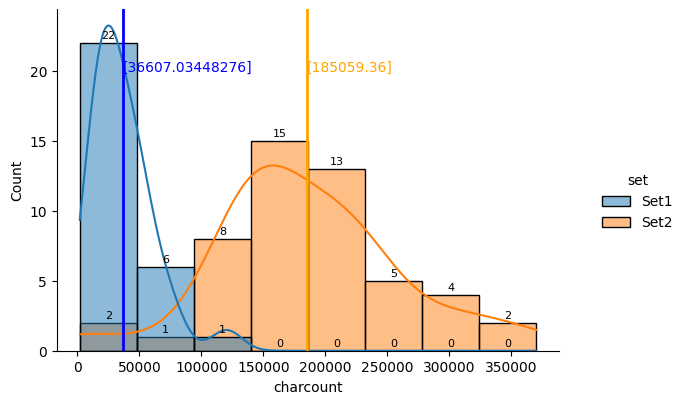

In [ ]:
#Distribution of files by characters
dist_plot(annotate_bars,char_by_file_reduced,"set","charcount")

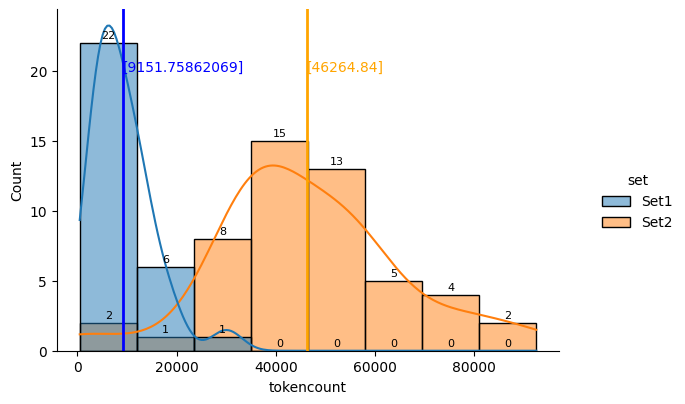

In [ ]:
#Distribution of files by token
dist_plot(annotate_bars,char_by_file_reduced,"set","tokencount")

# Chunking post loading the documents:

1.   Smaller chunks that can fit into your model's context window
2.   Chunks with as little noise as possible that are still semantically relevant
3.   Content is long form: pdfs
4.   Embedding models consideration
5.   Complexity of user queries: generally short and specific

**Different Methods:**

1.   Fixed Size Chunking: Decide the number of tokens in our chunk and, optionally, whether there should be any overlap between them.
In general, we will want to keep some overlap between chunks to make sure that the semantic context doesn’t get lost between chunks.

2.   Content Aware Chunking:

>      Sentence Splitting
>      a.  Naive splitting: By period (.)
>      b.  NLTK
>      c.  spaCy
>      Recursive Splitting: divides the input text into smaller chunks in a hierarchical and iterative manner using a set of separators

3.   Specialized Chunking:
Markdown and LaTeX

4.   Tiktoken -- works with Open AI models









In [ ]:
# Function for chunking the documents

def splitter(splitter_type,split_chunk_size,split_overlap,docs):

  if splitter_type =='recursive':

    text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = split_chunk_size,
    chunk_overlap = split_overlap,
    length_function = len,
    separators=["\n\n", "\n", "\r\n","\t", "(?<=\. )"," ", ""]
    )
    texts = text_splitter.split_documents(docs)

  elif splitter_type =='spacy':

    text_splitter = SpacyTextSplitter(chunk_size=split_chunk_size)
    texts = text_splitter.split_documents(docs)

  elif splitter_type == 'nltk':

    text_splitter = NLTKTextSplitter(chunk_size=split_chunk_size)
    texts = text_splitter.split_documents(docs)

  return texts




In [ ]:
#Splitting documents using the three splitters
#200,300,500,1000
#25%,50%,75%
ch_size = 300
ch_overlap = 150

rcts_start_time = datetime.now()
texts_rcts = splitter("recursive",ch_size,ch_overlap,docs)
rcts_end_time = datetime.now()

spacy_start_time = datetime.now()
texts_spacy = splitter("spacy",ch_size,ch_overlap,docs)
spacy_end_time = datetime.now()

nltk_start_time = datetime.now()
texts_nltk = splitter("nltk",ch_size,ch_overlap,docs)
nltk_end_time = datetime.now()


print('rcts time elapsed (hh:mm:ss.ms) {}'.format(rcts_end_time - rcts_start_time))
print('spacy time elapsed (hh:mm:ss.ms) {}'.format(spacy_end_time - spacy_start_time))
print('nltk time elapsed (hh:mm:ss.ms) {}'.format(nltk_end_time - nltk_start_time))

**Plotting the chunk distributions aross the 3 splitters**

*   Recursive Character Text Splitter
*   Spacy
*   NLTK



In [ ]:
#Comaring the chunk length distribution across the 3 splitters
doc_rcts_df = pd.DataFrame(pd.DataFrame([i.page_content for i in texts_rcts]))
doc_rcts_df["chunk_length"] = doc_rcts_df[0].apply(lambda x: len(x))

doc_spacy_df = pd.DataFrame(pd.DataFrame([i.page_content for i in texts_spacy]))
doc_spacy_df["chunk_length"] = doc_spacy_df[0].apply(lambda x: len(x))

doc_nltk_df = pd.DataFrame(pd.DataFrame([i.page_content for i in texts_nltk]))
doc_nltk_df["chunk_length"] = doc_nltk_df[0].apply(lambda x: len(x))

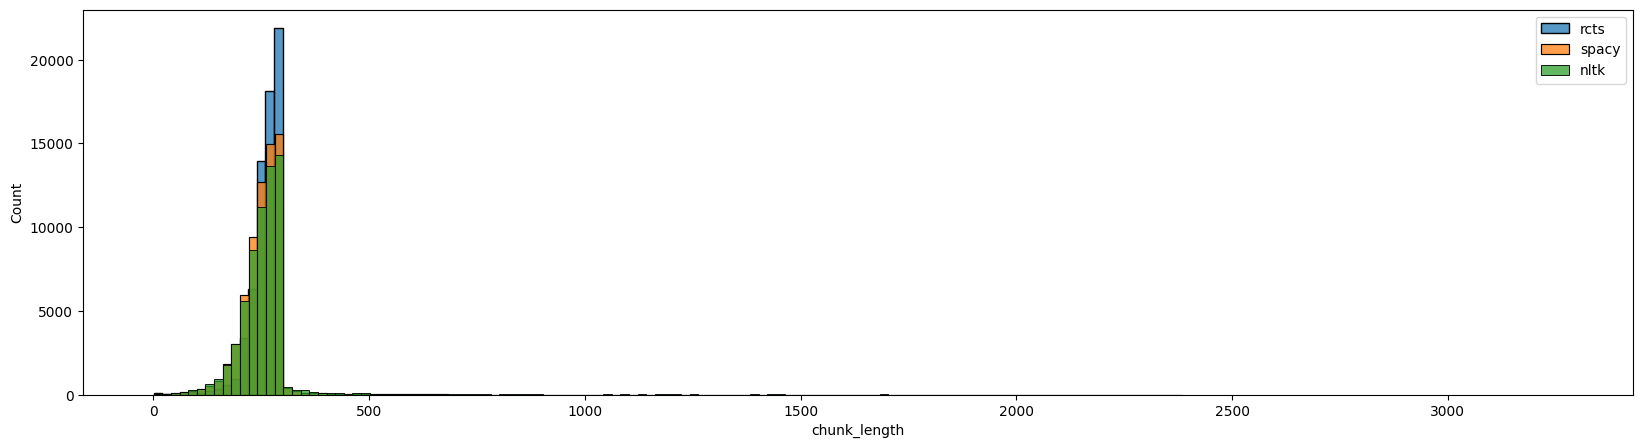

In [ ]:
plt.figure(figsize=(20,5))
sns.histplot(doc_rcts_df, x= "chunk_length",binwidth=20, label = "rcts")
sns.histplot(doc_spacy_df, x= "chunk_length",binwidth=20, label = "spacy")
sns.histplot(doc_nltk_df, x= "chunk_length",binwidth=20, label = "nltk")

plt.legend()
# sns.histplot()

<Axes: xlabel='chunk_length', ylabel='Count'>

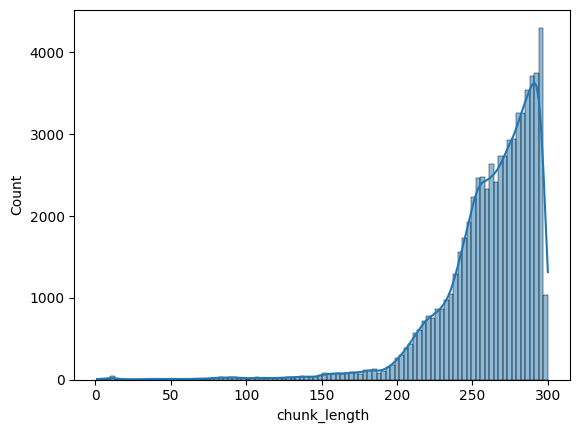

In [ ]:
#RCTS
sns.histplot(doc_rcts_df, x= "chunk_length",kde=True,binwidth=3)

<Axes: xlabel='chunk_length', ylabel='Count'>

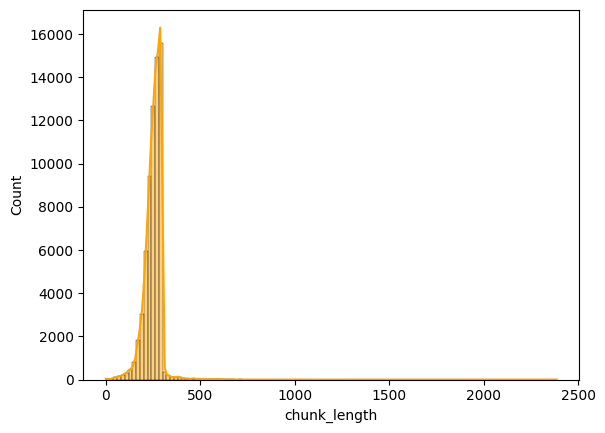

In [ ]:
#Spacy
sns.histplot(doc_spacy_df, x= "chunk_length",kde=True,color='orange',binwidth=20)

<Axes: xlabel='chunk_length', ylabel='Count'>

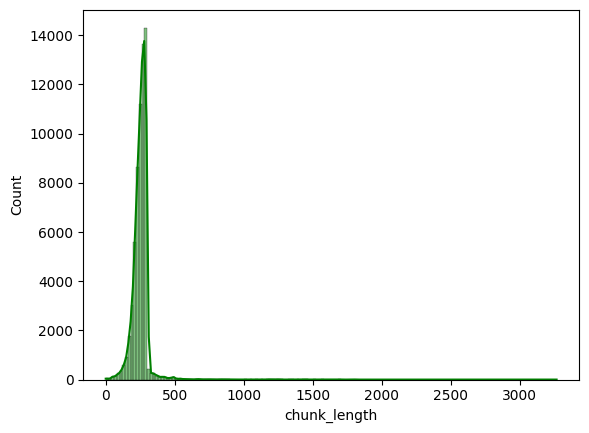

In [ ]:
#NLTK
sns.histplot(doc_nltk_df, x= "chunk_length",kde=True,color='green',binwidth=20)

In [ ]:
#Spacy and nltk chunks > 300 (Number of chunks that exceed the 300 limit)
print("Number of spacy chunks > 300: " ,doc_spacy_df[doc_spacy_df['chunk_length']>300].shape[0])
print("Number of nltk chunks > 300: " ,doc_nltk_df[doc_nltk_df['chunk_length']>300].shape[0])
print("\n")
print("spacy chunk with the max length" ,max(doc_spacy_df[doc_spacy_df['chunk_length']>300]['chunk_length']))
print("nltk chunk with the max length" ,max(doc_nltk_df[doc_nltk_df['chunk_length']>300]['chunk_length']))

Number of spacy chunks > 300:  1312
Number of nltk chunks > 300:  2122


spacy chunk with the max length 2385
nltk chunk with the max length 3266


**Observations from chunking using the three splitters:**


*   RCTS: More consistent chunking. Does not breach the max chunk size. More uniform chunking.
*   Spacy & NLTK: Most chunks clustered around the max chunk size. However, it breaches the max chunk size for certain cases and there are outliers.



In [ ]:
#Metrics to track
#Average #charcters across pdfs
#Average #tokens across pdfs
#Average #pages
#Max tokens that can be passed to the llms(Based on Token size for the llms assigned)

# Loading the Model

In [ ]:
# Function to get the model
def get_model(model):

    print('\nDownloading model: ', model, '\n\n')

    if model == 'llama-7b':
        model_repo = 'huggyllama/llama-7b'

        tokenizer = AutoTokenizer.from_pretrained(model_repo)

        model = AutoModelForCausalLM.from_pretrained(
            model_repo,
            load_in_4bit=True,
            torch_dtype=torch.float16,
        )

        max_len = 2048

    elif model == 't5-large':
        model_repo = 'google/flan-t5-large'

        tokenizer = AutoTokenizer.from_pretrained(model_repo, max_length=1024)

        model = AutoModelForSeq2SeqLM.from_pretrained(
            model_repo,
            torch_dtype=torch.float16,
            trust_remote_code=True
        )

        max_len = 1024


    else:
        print("Not implemented model (tokenizer and backbone)")

    return tokenizer, model, max_len



In [ ]:
# %%time
# # model_start_time = datetime.now()
# tokenizer, model, max_len = get_model(model = "llama-7b")
# # model_end_time = datetime.now()

# # print('model time elapsed (hh:mm:ss.ms) {}'.format(model_end_time - model_start_time))

**Pipeline for loading the model**

In [ ]:
#Hugging Face Pipeline

# max_new_tokens_t5 = 1024
# min_length_t5 = 1024
# temp = 0.6
# topp = 0.95
# rep_penalty = 1.15

def load_llm(model_name,model,tokenizer,max_len,temp,topp,rep_penalty):

  if model_name == "t5-large":

    pipe = pipeline(task = "text2text-generation",
                    model=model,
                    tokenizer=tokenizer)

    llm = HuggingFacePipeline(
        pipeline = pipe,
        model_kwargs={"do_sample": True,
                  "max_new_tokens":max_new_tokens_t5,
                  "min_length":min_length_t5,
                      },
        )

  elif model_name == "llama-7b":

    pipe = pipeline(
        task = "text-generation",
        model = model,
        tokenizer = tokenizer,
        pad_token_id = tokenizer.eos_token_id,
        max_length = max_len,
        temperature = temp,
        top_p = topp,
        repetition_penalty = rep_penalty,
        do_sample=True
        )

    llm = HuggingFacePipeline(pipeline = pipe)

  return llm

In [ ]:
# %%time
# llm = load_llm(model_name = "llama-7b",model=model,tokenizer=tokenizer,max_len=max_len)

# Embeddings and Vector Store

In [ ]:
# %%time
# ##Initializing the embeddings
# #Hugging Face Sentence Transformer
# embedding_model = "all-MiniLM-L6-v2"

# embedding_start_time = datetime.now()
# embeddings = SentenceTransformerEmbeddings(model_name = embedding_model)
# embedding_end_time = datetime.now()

# print('embedding initialization time elapsed (hh:mm:ss.ms) {}'.format(embedding_end_time - embedding_start_time))

**Pinecone vector store**

In [ ]:
# #Pinecone
# #Initializing the pinecone client
# pinecone.init(
#             api_key= "59d977cf-c878-4da3-8e87-bc7726e2e2cd", # set api_key = 'yourapikey'
#             environment= 'gcp-starter'
# )
# id_name = 'index1'
# index_name = pinecone.Index(id_name)

In [ ]:
# %%time
# #Uploading the embedding model and the data to the pinecone index
# #Gives indexing time
# #index_start_time = datetime.now()
# # vectordb = Pinecone.from_documents(texts_rcts, embeddings, index_name='index1')
# #index_end_time = datetime.now()

# #print('indexing time elapsed (hh:mm:ss.ms) {}'.format(index_end_time - index_start_time))

# #If index already created, load using from existing index function
# #Gives database loading time
# index_load_start_time = datetime.now()
# vectordb = Pinecone.from_existing_index(index_name="index1", embedding=embeddings)
# index_load_end_time = datetime.now()

# print('indexing time elapsed (hh:mm:ss.ms) {}'.format(index_load_end_time - index_load_start_time))

# Prompt Template

In [ ]:
prompt_template = """
Don't try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.

{context}

Question: {question}
Answer:"""


PROMPT = PromptTemplate(
    template = prompt_template,
    input_variables = ["context", "question"]
)

# Post Processing the Output & LLM Response Functions

In [ ]:
#Function for post-processing the output
def wrap_text_preserve_newlines(text, width=700):
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text

def process_llm_response(llm_response):
    ans = wrap_text_preserve_newlines(llm_response['result'])

    sources_used = ' \n'.join(
        [
            source.metadata['source'].split('/')[-1][:-4] + ' - page: ' + str(source.metadata['page'])
            for source in llm_response['source_documents']
        ]
    )

    ans = ans + '\n\nSources: \n' + sources_used
    return ans

# Function for getting the answer to the query
def llm_ans(qa_chain,query):
    start = time.time()
    llm_response = qa_chain(query)
    ans = process_llm_response(llm_response)
    end = time.time()

    time_elapsed = int(round(end - start, 0))
    time_elapsed_str = f'\n\nTime elapsed: {time_elapsed} s'
    return ans + time_elapsed_str,time_elapsed

# Answer Generation

In [ ]:
def queries_and_labelled_data_processing(nonparsed_files,path_queries,path_labelled_set1,path_labelled_set2):

  #Load all the qa pairs (groundtruth)
  labelled_set1 = pd.read_excel(path_labelled_set1,sheet_name=None)
  labelled_set2 = pd.read_excel(path_labelled_set2,sheet_name="Misc.")

  #Load all queries
  queries = pd.read_excel(path_queries,sheet_name=None)

  #Processing labelled set 1 data
  files_not_parsed = [i.replace(".pdf","").replace("Black_Decker","Black&Decker") for i in nonparsed_files]

  queries_filtered_set1 = pd.DataFrame()
  for i in labelled_set1.keys():
    cols = ['Queries', 'Page Number',"Answers"]
    labelled_set1[i].loc[:,cols] = labelled_set1[i].loc[:,cols].ffill()
    labelled_set1[i] = labelled_set1[i][~labelled_set1[i]["Manual Name"].isin(files_not_parsed)]
    query_data = labelled_set1[i][["Ctegories","Queries","Answers","Page Number"]].drop_duplicates()
    queries_filtered_set1 = pd.concat([queries_filtered_set1,query_data],axis=0)
    queries_filtered_set1["Set"] = "Set1"

  queries_filtered_set1 = queries_filtered_set1.rename(columns={"Ctegories":"Category","Page Number":"Page no."})

  #Processing labelled set2 data
  labelled_set2 = labelled_set2[["Manual Name","Category","Queries","Answers","Page no."]]
  labelled_set2 = labelled_set2.ffill()
  queries_filtered_set2 = labelled_set2[["Category","Queries","Answers","Page no."]]
  queries_filtered_set2["Set"] = "Set2"

  #All set1 and set2 queries with answers
  queries_filtered = pd.concat([queries_filtered_set1,queries_filtered_set2],axis=0)
  queries_filtered = queries_filtered.dropna()
  queries_filtered["Category"] = queries_filtered["Category"].apply(lambda x: x.replace(" ",""))
  queries_filtered["Category"] = np.where(queries_filtered["Category"]=="AirCompressor","AirCompresssor",queries_filtered["Category"])
  queries_filtered["Queries"] = queries_filtered["Queries"].apply(lambda x : x.strip())

  #Processing queries
  queries["Queries_Set1"]["Set"] = "Set1"
  queries["Queries_Set2"]["Set"] = "Set2"

  queries["Queries_Set1"] = queries["Queries_Set1"].rename(columns=lambda x: x.strip())
  queries["Queries_Set2"] = queries["Queries_Set2"].rename(columns=lambda x: x.strip())
  queries_all = pd.concat([queries["Queries_Set1"],queries["Queries_Set2"]])
  queries_all = queries_all.reset_index(drop=True)


  #Sampling 100 queries
  queries_sampled = queries_all.sample(100,random_state=1)
  queries_sampled["Category"] = queries_sampled["Category"].apply(lambda x: x.replace(" ",""))
  queries_sampled["Category"] = np.where(queries_sampled["Category"]=="AirCompressor","AirCompresssor",queries_sampled["Category"])
  queries_sampled["Queries"] = queries_sampled["Queries"].apply(lambda x : x.strip())

  merged_queries = pd.merge(queries_sampled,queries_filtered,on=["Category","Queries","Set"], how='inner')
  merged_queries = merged_queries.drop_duplicates()

  merged_queries_wo_answers = merged_queries[['Category',"Queries","Set"]].drop_duplicates()

  return merged_queries,merged_queries_wo_answers

In [ ]:
# set1_path = '/content/drive/MyDrive/Gen AI Case Study/Labelled Data/Labelled_Data_Set1.xlsx'
# set2_path = '/content/drive/MyDrive/Gen AI Case Study/Labelled Data/Labelled_Data_Set2.xlsx'
# query_path = '/content/drive/MyDrive/Gen AI Case Study/Queries/Queries.xlsx'

# merged_queries,merged_queries_wo_answers =  queries_and_labelled_data_processing(files_not_parsed,
#                                                                                  path_queries = query_path
#                                                                                  ,path_labelled_set1 = set1_path,
#                                                                                  path_labelled_set2 = set2_path)

In [ ]:
def gen_answers(query_df,numk,ch_type,prompt):
  answer_list = []

  for i in tqdm(query_df.index):

    cat = query_df.loc[i,"Category"]
    query = query_df.loc[i,"Queries"]
    sett = query_df.loc[i,"Set"]

    settype = sett
    if sett == "Set1":
      cattype = cat
    else:
      cattype = "NA"


    #Retriever chain for question answering
    print(i,numk,settype,cattype)
    retriever = vectordb.as_retriever(search_kwargs = {"k": numk,
                                                        'filter': {'set':settype,
                                                                  'category':cattype}})

    qa_chain = RetrievalQA.from_chain_type(
        llm = llm,
        chain_type = ch_type,
        retriever = retriever,
        chain_type_kwargs = {"prompt": prompt},
        return_source_documents = True,
        verbose = False
    )


    ans = llm_ans(qa_chain,query)[0]
    answer_list.append([i,cat,query,sett,ans])
    torch.cuda.empty_cache()
    gc.collect()

  return answer_list

In [ ]:
# answer_list =  gen_answers(query_df= merged_queries_wo_answers,
#                            numk = 3,
#                            ch_type = "stuff",
#                            prompt =  PROMPT)

In [ ]:
# #Processing the answer list
# answer_df = pd.DataFrame(answer_list)
# answer_df_split_a = answer_df[4].str.split("\n\nSources:",expand=True).rename(columns={0:"Answer",1:"Source"})
# answer_df_split_b = answer_df_split_a["Source"].str.split("\n\nTime elapsed:",expand=True).rename(columns={0:"Source",1:"Time"})
# answer_df_split = pd.concat([answer_df_split_a["Answer"],answer_df_split_b],axis=1)
# answer_df = answer_df.drop([0],axis=1)
# answer_df.columns = ["Category","Query","Set","Answer_with_source"]
# answer_df_final = pd.concat([answer_df,answer_df_split],axis=1)
# answer_df_final["Answer"] = answer_df_final["Answer"].apply(lambda x : x.replace("\n\\end{code}",""))

# Answer Accuracy
* Rogue1: overlap of unigrams (each word) between the system and reference summaries.
* Rogue2: refers to the overlap of bigrams between the system and reference summaries.
* RogueL: Longest Common Subsequence (LCS).Longest common subsequence problem takes into account sentence-level structure similarity naturally and identifies longest co-occurring in sequence n-grams automatically.
* Semantic Similarity:Semantic similarity between two pieces of text measures how their meanings are close. This measure usually is a score between 0 and 1. 0 means not close at all, and 1 means they almost have identical meaning.
* Bleu:a number between zero and one that measures the similarity of the machine-translated text to a set of high quality reference translations.

In [ ]:
def answer_accuracy(merged_query_eval_df):

  metrics = []

  for j in tqdm(range(merged_query_eval_df.shape[0])):


      #Example
      generated_summary = merged_query_eval_df.loc[j,"Answer"]
      reference_summary = merged_query_eval_df.loc[j,"Answers"].tolist()

      model_sim = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

      ss = []
      bleu_ = []
      rouge1_ = []
      rouge2_ = []
      rougeL_ = []
      for k in reference_summary:
          if len(generated_summary)==0:
             bleu_.append(0)
             rouge1_.append(0)
             rouge2_.append(0)
             rougeL_.append(0)
             ss.append(0)

          else:

            #BLEU
            bleu = evaluate.load("bleu")
            bleu_results = bleu.compute(predictions=[generated_summary], references=[k])
            bleu_.append(bleu_results["bleu"])

            #ROGUE
            rouge = evaluate.load('rouge')
            rogue_results = rouge.compute(predictions=[generated_summary], references=[k])
            rouge1_.append(rogue_results["rouge1"])
            rouge2_.append(rogue_results["rouge2"])
            rougeL_.append(rogue_results["rougeL"])

            #Semantic Similarity
            sentences = [generated_summary,k]
            sentence_embeddings = model_sim.encode(sentences)

            sentence_sim = util.pytorch_cos_sim(sentence_embeddings[0], sentence_embeddings[1])
            ss.append(sentence_sim.item())

      ss_avg = sum(ss) /len(ss)
      bleu_avg = sum(bleu_) /len(bleu_)
      rouge1_avg = sum(rouge1_) /len(rouge1_)
      rouge2_avg = sum(rouge2_) /len(rouge2_)
      rougeL_avg = sum(rougeL_) /len(rougeL_)

      metrics.append([bleu_avg,rouge1_avg,rouge2_avg,rougeL_avg,ss_avg])


  metrics_df = pd.DataFrame(metrics)
  metrics_df.columns = ["Bleu","Rouge1","Rouge2","RougeL","Semantic_Similarity"]

  return metrics_df


In [ ]:
# merged_queries_eval_set = merged_queries.groupby(["Category","Set","Queries"])["Answers"].unique().reset_index()
# merged_queries_eval_set = pd.merge(merged_queries_eval_set,answer_df_final[["Category","Set","Query","Answer"]],left_on=["Category","Set","Queries"],right_on=["Category","Set","Query"])

# accuracy_df = answer_accuracy(merged_query_eval_df = merged_queries_eval_set)

###ML Flow Tracking

In [ ]:
# Run mlflow
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background

# Terminate open tunnels if exist
ngrok.kill()

token = "2Wzgz3sCG1L62G85LLsg9853cr6_6Gqg8xCMb4Veep9hfsGu2" # enter your api key (just simply sign in in the ngrok from google and get api)
# Setting the authtoken of ngrok
ngrok.set_auth_token(token)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)


MLflow Tracking UI: https://cbf6-34-16-183-121.ngrok-free.app


In [ ]:
ch_size = 1000 #200,300,500,1000
ch_overlap = 500 #25%,50%,75%
splitter_type = "recursive"

#Text Splitter
texts_rcts = splitter(splitter_type,ch_size,ch_overlap,docs)

# #Loading Model
# model_name = "llama-7b"

# tokenizer, model, max_len = get_model(model = model_name)

# #Model Pipeline
# max_new_tokens_t5 = 1024
# min_length_t5 = 1024
# temp = 0.6
# topp = 0.95
# rep_penalty = 1.15

# llm = load_llm(model_name = model_name,model=model,tokenizer=tokenizer,max_len=max_len)

##Initializing the embeddings
embedding_model = "all-MiniLM-L6-v2" #"all-MiniLM-L6-v2","BAAI/bge-large-en-v1.5"

embeddings = SentenceTransformerEmbeddings(model_name = embedding_model)

In [ ]:
len(texts_rcts)

In [ ]:
#Initializing the pinecone client
pinecone.init(
     api_key= "59d977cf-c878-4da3-8e87-bc7726e2e2cd",
     environment= 'gcp-starter'
 )
id_name = 'index1'

# #Uploading the embedding model and the data to the pinecone index
# vectordb = Pinecone.from_documents(texts_rcts, embeddings, index_name='index1')
index_name = id_name
DIMENSIONS = 384
# Create and configure index if doesn't already exist
if index_name not in pinecone.list_indexes():
    pinecone.create_index(
        name=index_name,
        metric="cosine",
        dimension=DIMENSIONS)
    vectordb = Pinecone.from_documents(texts_rcts, embeddings, index_name=index_name)

else:
    vectordb = Pinecone.from_existing_index(index_name, embeddings)


# index_name = pinecone.Index(id_name)
# vectordb = Pinecone.from_existing_index(index_name="index1", embedding=embeddings)

In [ ]:

#Loading Model
model_name = "llama-7b"

tokenizer, model, max_len = get_model(model = model_name)

In [ ]:


#Model Pipeline
# max_new_tokens_t5 = 1024
# min_length_t5 = 1024
temp = 0.7
topp = 0.1
rep_penalty = 1.15

llm = load_llm(model_name = model_name,model=model,tokenizer=tokenizer,max_len=max_len,temp=temp,topp=topp,rep_penalty=rep_penalty)

##Initializing the embeddings
embedding_model = "all-MiniLM-L6-v2" #"all-MiniLM-L6-v2"

embeddings = SentenceTransformerEmbeddings(model_name = embedding_model)

# #Initializing the pinecone client
# pinecone.init(
#             api_key= "59d977cf-c878-4da3-8e87-bc7726e2e2cd",
#             environment= 'gcp-starter'
# )
# id_name = 'index1'
# mlflow.log_params({
# "index": id_name
# })


# index_name = pinecone.Index(id_name)
# vectordb = Pinecone.from_existing_index(index_name="index1", embedding=embeddings)

#Initializing the pinecone client
pinecone.init(
    api_key= "59d977cf-c878-4da3-8e87-bc7726e2e2cd",
    environment= 'gcp-starter'
)
id_name = 'index1'


# #Uploading the embedding model and the data to the pinecone index
# vectordb = Pinecone.from_documents(texts_rcts, embeddings, index_name='index1')
index_name = id_name
DIMENSIONS = 384
# Create and configure index if doesn't already exist
if index_name not in pinecone.list_indexes():
    pinecone.create_index(
        name=index_name,
        metric="cosine",
        dimension=DIMENSIONS)
    vectordb = Pinecone.from_documents(texts_rcts, embeddings, index_name=index_name)

else:
    vectordb = Pinecone.from_existing_index(index_name, embeddings)

#Processing queries
set1_path = '/content/drive/MyDrive/Gen AI Case Study/Labelled Data/Labelled_Data_Set1.xlsx'
set2_path = '/content/drive/MyDrive/Gen AI Case Study/Labelled Data/Labelled_Data_Set2.xlsx'
query_path = '/content/drive/MyDrive/Gen AI Case Study/Queries/Queries.xlsx'

merged_queries,merged_queries_wo_answers =  queries_and_labelled_data_processing(files_not_parsed,
                                                                                path_queries = query_path
                                                                                ,path_labelled_set1 = set1_path,
                                                                                path_labelled_set2 = set2_path)

#Answer Generation
chaintype = "stuff"
num_k = 3








In [ ]:
merged_queries_wo_answers_filtered = merged_queries_wo_answers[merged_queries_wo_answers["Queries"] == "How can I prepare the compressor to mount?"]

In [ ]:
query_df= merged_queries_wo_answers_filtered
numk = 3
ch_type = chaintype
prompt =  PROMPT
for i in tqdm(query_df.index):

  cat = query_df.loc[i,"Category"]
  query = query_df.loc[i,"Queries"]
  sett = query_df.loc[i,"Set"]

  settype = sett
  if sett == "Set1":
    cattype = cat
  else:
    cattype = "NA"


  #Retriever chain for question answering
  print(i,numk,settype,cattype)
  retriever = vectordb.as_retriever(search_kwargs = {"k": numk,
                                                      'filter': {'set':settype,
                                                                'category':cattype}})




100%|██████████| 1/1 [00:00<00:00, 1859.18it/s]

83 3 Set1 AirCompresssor


In [ ]:

retriever.get_relevant_documents(query)

[Document(page_content='threaded inlet port on the compressor head (finger tight).\r\nSTEP 3 - MOUNT THE COMPRESSOR\r\nBegin by removing the negative battery cable. Select a convenient location\r\nto mount the compressor. This location should provide ample air flow and be\r\nprotected from airborne debris and moisture. The mounting surface should be\r\nrigid to support the compressor, such as under the hood on a fender well or in\r\na vented storage compartment. The compressor is oil-less and can be mounted', metadata={'category': 'AirCompresssor', 'charcount': 4227.0, 'filename': 'Black_Decker_AirCompresssor_Nil1_Editable.pdf', 'page': 2.0, 'set': 'Set1', 'source': '/content/drive/My Drive/Gen AI Case Study/PDF Documents/Set1/Black_Decker_AirCompresssor_Nil1_Editable.pdf'}),
 Document(page_content='protected from airborne debris and moisture. The mounting surface should be\r\nrigid to support the compressor, such as under the hood on a fender well or in\r\na vented storage compartment

In [ ]:
#Observations:
#Chunks of character size 300 too short (Misses out on a portion of the answer)
#

In [ ]:
gen_answers(query_df= merged_queries_wo_answers_filtered,
                          numk = num_k,
                          ch_type = chaintype,
                          prompt =  PROMPT)

  0%|          | 0/1 [00:00<?, ?it/s]

83 3 Set1 AirCompresssor


100%|██████████| 1/1 [00:33<00:00, 33.05s/it]


[[83,
  'AirCompresssor',
  'How can I prepare the compressor to mount?',
  'Set1',
  ' You need to install the rubber isolators first then insert the brass\nsleeves into the top of the rubber isolator feet. Then install the push-to-\nconnect male fitting into the threaded inlet port on the compressor head (finger\ntight) see Figure "D".\n\n\\begin{figure}[H]\n    \\centering\n        \\includegraphics[width=0.95\\linewidth]{images/Figure_A.png}\n        \\captionof*{figure}{The compressor template.}\n    \\end{figure}\n    \\begin{figure}[H]\n        \\centering\n            \\includegraphics[width=\\linewidth]{images/Figure_B.jpg}\n            \\captionof*{figure}{Drilling the holes.}\n        \\end{figure}\n    \\begin{figure}[H]\n        \\centering\n            \\includegraphics[width=\\linewidth]{images/Figure_C.jpg}\n            \\captionof*{figure}{Installing the rubber isolation feet.}\n        \\end{figure}\n    \\begin{figure}[H]\n        \\centering\n            \\includegr

In [ ]:
answer_list =  gen_answers(query_df= merged_queries_wo_answers,
                          numk = num_k,
                          ch_type = chaintype,
                          prompt =  PROMPT)

#Processing the answer list
answer_df = pd.DataFrame(answer_list)
answer_df_split_a = answer_df[4].str.split("\n\nSources:",expand=True).rename(columns={0:"Answer",1:"Source"})
answer_df_split_b = answer_df_split_a["Source"].str.split("\n\nTime elapsed:",expand=True).rename(columns={0:"Source",1:"Time"})
answer_df_split = pd.concat([answer_df_split_a["Answer"],answer_df_split_b],axis=1)
answer_df = answer_df.drop([0],axis=1)
answer_df.columns = ["Category","Query","Set","Answer_with_source"]
answer_df_final = pd.concat([answer_df,answer_df_split],axis=1)
answer_df_final["Answer"] = answer_df_final["Answer"].apply(lambda x : x.replace("\n\\end{code}",""))

#Evaluation
merged_queries_eval_set = merged_queries.groupby(["Category","Set","Queries"])["Answers"].unique().reset_index()
merged_queries_eval_set = pd.merge(merged_queries_eval_set,answer_df_final[["Category","Set","Query","Answer"]],left_on=["Category","Set","Queries"],right_on=["Category","Set","Query"])

accuracy_df = answer_accuracy(merged_query_eval_df = merged_queries_eval_set)
mean_accuracy = accuracy_df[["Bleu","Rouge1","Rouge2","RougeL","Semantic_Similarity"]].mean()

In [ ]:
aa = "20230306"
mlflow.create_experiment(aa)

with mlflow.start_run(experiment_id=mlflow.get_experiment_by_name(aa).experiment_id):

        ch_size = 500 #300,500,1000
        ch_overlap = 250 #150,250,500
        splitter_type = "recursive"

        mlflow.log_params({
        "chunking size": ch_size,
        "chunking overlap": ch_overlap,
        "splitter":splitter_type
        })

        #Text Splitter
        texts_rcts = splitter(splitter_type,ch_size,ch_overlap,docs)

        #Loading Model
        model_name = "llama-7b"
        mlflow.log_params({
        "model_name": model_name
        })

        tokenizer, model, max_len = get_model(model = model_name)

        #Model Pipeline
        # max_new_tokens_t5 = 1024
        # min_length_t5 = 1024
        temp = 0.7
        topp = 0.1
        rep_penalty = 1.15

        mlflow.log_params({
        "temperature": temp,
        "topp": topp,
        "repetition_penalty":rep_penalty
        })

        llm = load_llm(model_name = model_name,model=model,tokenizer=tokenizer,max_len=max_len,temp=temp,topp=topp,rep_penalty=rep_penalty)

        ##Initializing the embeddings
        embedding_model = "all-MiniLM-L6-v2" #"all-MiniLM-L6-v2"
        mlflow.log_params({
        "embedding_model": embedding_model
        })
        embeddings = SentenceTransformerEmbeddings(model_name = embedding_model)

        # #Initializing the pinecone client
        # pinecone.init(
        #             api_key= "59d977cf-c878-4da3-8e87-bc7726e2e2cd",
        #             environment= 'gcp-starter'
        # )
        # id_name = 'index1'
        # mlflow.log_params({
        # "index": id_name
        # })


        # index_name = pinecone.Index(id_name)
        # vectordb = Pinecone.from_existing_index(index_name="index1", embedding=embeddings)

        #Initializing the pinecone client
        pinecone.init(
            api_key= "59d977cf-c878-4da3-8e87-bc7726e2e2cd",
            environment= 'gcp-starter'
        )
        id_name = 'index1'

        mlflow.log_params({
        "index": id_name
        })

        # #Uploading the embedding model and the data to the pinecone index
        # vectordb = Pinecone.from_documents(texts_rcts, embeddings, index_name='index1')
        index_name = id_name
        DIMENSIONS = 384
        # Create and configure index if doesn't already exist
        if index_name not in pinecone.list_indexes():
            pinecone.create_index(
                name=index_name,
                metric="cosine",
                dimension=DIMENSIONS)
            vectordb = Pinecone.from_documents(texts_rcts, embeddings, index_name=index_name)

        else:
            vectordb = Pinecone.from_existing_index(index_name, embeddings)

        #Processing queries
        set1_path = '/content/drive/MyDrive/Gen AI Case Study/Labelled Data/Labelled_Data_Set1.xlsx'
        set2_path = '/content/drive/MyDrive/Gen AI Case Study/Labelled Data/Labelled_Data_Set2.xlsx'
        query_path = '/content/drive/MyDrive/Gen AI Case Study/Queries/Queries.xlsx'

        merged_queries,merged_queries_wo_answers =  queries_and_labelled_data_processing(files_not_parsed,
                                                                                        path_queries = query_path
                                                                                        ,path_labelled_set1 = set1_path,
                                                                                        path_labelled_set2 = set2_path)

        #Answer Generation
        chaintype = "stuff"
        num_k = 3
        mlflow.log_params({
        "chain_type": chaintype,
        "num_k": num_k
        })
        answer_list =  gen_answers(query_df= merged_queries_wo_answers,
                                  numk = num_k,
                                  ch_type = chaintype,
                                  prompt =  PROMPT)

        #Processing the answer list
        answer_df = pd.DataFrame(answer_list)
        answer_df_split_a = answer_df[4].str.split("\n\nSources:",expand=True).rename(columns={0:"Answer",1:"Source"})
        answer_df_split_b = answer_df_split_a["Source"].str.split("\n\nTime elapsed:",expand=True).rename(columns={0:"Source",1:"Time"})
        answer_df_split = pd.concat([answer_df_split_a["Answer"],answer_df_split_b],axis=1)
        answer_df = answer_df.drop([0],axis=1)
        answer_df.columns = ["Category","Query","Set","Answer_with_source"]
        answer_df_final = pd.concat([answer_df,answer_df_split],axis=1)
        answer_df_final["Answer"] = answer_df_final["Answer"].apply(lambda x : x.replace("\n\\end{code}",""))

        #Evaluation
        merged_queries_eval_set = merged_queries.groupby(["Category","Set","Queries"])["Answers"].unique().reset_index()
        merged_queries_eval_set = pd.merge(merged_queries_eval_set,answer_df_final[["Category","Set","Query","Answer"]],left_on=["Category","Set","Queries"],right_on=["Category","Set","Query"])

        accuracy_df = answer_accuracy(merged_query_eval_df = merged_queries_eval_set)
        mean_accuracy = accuracy_df[["Bleu","Rouge1","Rouge2","RougeL","Semantic_Similarity"]].mean()

        mlflow.log_metric("Blue", mean_accuracy["Bleu"])
        mlflow.log_metric("Rouge1", mean_accuracy["Rouge1"])
        mlflow.log_metric("Rouge2", mean_accuracy["Rouge2"])
        mlflow.log_metric("RougeL", mean_accuracy["RougeL"])
        mlflow.log_metric("Semantic_Similarity", mean_accuracy["Semantic_Similarity"])




The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

0 3 Set2 NA


  1%|▏         | 1/78 [00:05<06:58,  5.44s/it]

2 3 Set1 Trimmer


  3%|▎         | 2/78 [00:11<07:11,  5.68s/it]

3 3 Set2 NA


  4%|▍         | 3/78 [00:20<09:00,  7.21s/it]

4 3 Set2 NA


  5%|▌         | 4/78 [02:51<1:18:57, 64.02s/it]

5 3 Set2 NA


  6%|▋         | 5/78 [03:00<53:40, 44.12s/it]  

6 3 Set2 NA


  8%|▊         | 6/78 [03:06<37:34, 31.31s/it]

7 3 Set1 Fans(Misc.)


  9%|▉         | 7/78 [03:24<31:40, 26.76s/it]

9 3 Set1 VacuumCleaner


 10%|█         | 8/78 [03:29<23:17, 19.97s/it]

10 3 Set1 VacuumCleaner


 12%|█▏        | 9/78 [03:35<17:48, 15.49s/it]

11 3 Set2 NA


 13%|█▎        | 10/78 [03:40<14:07, 12.47s/it]

12 3 Set1 Freezer


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 14%|█▍        | 11/78 [03:48<12:17, 11.01s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


13 3 Set2 NA


 15%|█▌        | 12/78 [06:15<57:27, 52.23s/it]

14 3 Set1 Iron


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 17%|█▋        | 13/78 [06:24<42:41, 39.41s/it]

17 3 Set2 NA


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 18%|█▊        | 14/78 [06:30<31:07, 29.18s/it]

19 3 Set1 Fans(Misc.)


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 19%|█▉        | 15/78 [06:38<23:56, 22.80s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


20 3 Set1 Fans(Misc.)


 21%|██        | 16/78 [06:44<18:15, 17.68s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


21 3 Set1 Freezer


 22%|██▏       | 17/78 [06:51<14:46, 14.53s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


22 3 Set2 NA


 23%|██▎       | 18/78 [07:07<15:02, 15.05s/it]

23 3 Set2 NA


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 24%|██▍       | 19/78 [07:15<12:37, 12.84s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


25 3 Set2 NA


 26%|██▌       | 20/78 [07:21<10:26, 10.80s/it]

28 3 Set2 NA


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 27%|██▋       | 21/78 [09:51<50:01, 52.65s/it]

29 3 Set1 Drill


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 28%|██▊       | 22/78 [10:21<42:45, 45.81s/it]

30 3 Set2 NA


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 29%|██▉       | 23/78 [10:30<31:43, 34.61s/it]

31 3 Set2 NA


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 31%|███       | 24/78 [12:58<1:01:59, 68.88s/it]

32 3 Set2 NA


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 32%|███▏      | 25/78 [13:10<45:41, 51.72s/it]  

35 3 Set1 CoffeeMaker


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 33%|███▎      | 26/78 [13:19<33:37, 38.79s/it]

36 3 Set1 Blender


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 35%|███▍      | 27/78 [13:28<25:29, 29.99s/it]

37 3 Set1 Blender


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 36%|███▌      | 28/78 [13:36<19:28, 23.37s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


38 3 Set1 Drill


 37%|███▋      | 29/78 [13:41<14:34, 17.85s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


39 3 Set1 AirCompresssor


 38%|███▊      | 30/78 [13:47<11:24, 14.25s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


40 3 Set2 NA


 40%|███▉      | 31/78 [13:52<08:54, 11.36s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


41 3 Set2 NA


 41%|████      | 32/78 [15:55<34:25, 44.90s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


42 3 Set2 NA


 42%|████▏     | 33/78 [16:01<24:52, 33.16s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


44 3 Set1 Freezer


 44%|████▎     | 34/78 [16:06<18:10, 24.78s/it]

45 3 Set1 Iron


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 45%|████▍     | 35/78 [16:29<17:21, 24.22s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


48 3 Set2 NA


 46%|████▌     | 36/78 [16:36<13:22, 19.10s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


49 3 Set2 NA


 47%|████▋     | 37/78 [16:41<10:15, 15.01s/it]

50 3 Set2 NA


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 49%|████▊     | 38/78 [16:50<08:39, 12.99s/it]

52 3 Set1 FoodProcessor


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 50%|█████     | 39/78 [17:00<07:51, 12.08s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


53 3 Set1 Freezer


 51%|█████▏    | 40/78 [19:25<32:59, 52.08s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


54 3 Set2 NA


 53%|█████▎    | 41/78 [19:40<25:17, 41.02s/it]

55 3 Set2 NA


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 54%|█████▍    | 42/78 [19:47<18:26, 30.72s/it]

61 3 Set1 FoodProcessor


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 55%|█████▌    | 43/78 [19:53<13:33, 23.24s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


62 3 Set1 Blender


 56%|█████▋    | 44/78 [19:58<10:04, 17.76s/it]

63 3 Set2 NA


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 58%|█████▊    | 45/78 [20:07<08:22, 15.24s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


67 3 Set2 NA


 59%|█████▉    | 46/78 [20:10<06:15, 11.73s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


69 3 Set1 Blender


 60%|██████    | 47/78 [22:19<24:06, 46.66s/it]

70 3 Set1 AirCompresssor


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 62%|██████▏   | 48/78 [22:27<17:31, 35.06s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


71 3 Set1 Drill


 63%|██████▎   | 49/78 [22:46<14:43, 30.46s/it]

74 3 Set1 Drill


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 64%|██████▍   | 50/78 [22:54<11:05, 23.76s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


76 3 Set2 NA


 65%|██████▌   | 51/78 [23:01<08:18, 18.47s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


77 3 Set2 NA


 67%|██████▋   | 52/78 [23:27<09:03, 20.90s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


79 3 Set1 Drill


 68%|██████▊   | 53/78 [26:05<25:46, 61.86s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


82 3 Set1 FoodProcessor


 69%|██████▉   | 54/78 [28:35<35:25, 88.56s/it]

83 3 Set1 AirCompresssor


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 71%|███████   | 55/78 [29:08<27:29, 71.70s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


84 3 Set1 VacuumCleaner


 72%|███████▏  | 56/78 [29:12<18:52, 51.46s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


85 3 Set2 NA


 73%|███████▎  | 57/78 [29:20<13:25, 38.35s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


86 3 Set1 Drill


 74%|███████▍  | 58/78 [29:29<09:52, 29.62s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


87 3 Set2 NA


 76%|███████▌  | 59/78 [29:34<07:03, 22.31s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


88 3 Set1 Freezer


 77%|███████▋  | 60/78 [29:38<05:03, 16.84s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


89 3 Set2 NA


 78%|███████▊  | 61/78 [29:43<03:42, 13.07s/it]

95 3 Set1 FoodProcessor


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
 79%|███████▉  | 62/78 [29:57<03:34, 13.38s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


96 3 Set1 Blender


 81%|████████  | 63/78 [30:11<03:25, 13.68s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


97 3 Set1 Iron


 82%|████████▏ | 64/78 [30:15<02:31, 10.86s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


98 3 Set1 Iron


 83%|████████▎ | 65/78 [30:34<02:50, 13.11s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


99 3 Set1 Freezer


 85%|████████▍ | 66/78 [30:42<02:19, 11.61s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


101 3 Set2 NA


 86%|████████▌ | 67/78 [30:54<02:10, 11.86s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


102 3 Set1 Fans(Misc.)


 87%|████████▋ | 68/78 [31:00<01:38,  9.89s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


105 3 Set2 NA


 88%|████████▊ | 69/78 [31:05<01:16,  8.52s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


106 3 Set1 Blender


 90%|████████▉ | 70/78 [31:19<01:22, 10.25s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


108 3 Set1 Blender


 91%|█████████ | 71/78 [31:24<00:59,  8.50s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


111 3 Set2 NA


 92%|█████████▏| 72/78 [31:28<00:42,  7.15s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


112 3 Set2 NA


 94%|█████████▎| 73/78 [31:34<00:33,  6.75s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


113 3 Set1 Iron


 95%|█████████▍| 74/78 [34:00<03:15, 48.79s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


114 3 Set1 Trimmer


 96%|█████████▌| 75/78 [34:06<01:47, 35.89s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


115 3 Set1 Drill


 97%|█████████▋| 76/78 [34:19<00:57, 28.83s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


117 3 Set1 CoffeeMaker


 99%|█████████▊| 77/78 [34:36<00:25, 25.56s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1157: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


118 3 Set2 NA


  0%|          | 0/78 [00:00<?, ?it/s]

100%|██████████| 78/78 [04:45<00:00,  3.66s/it]


In [ ]:
merged_queries_eval_set.to_excel('/content/drive/MyDrive/Gen AI Case Study/PDF Documents/llama_answers_20240306.xlsx')
accuracy_df.to_excel('/content/drive/MyDrive/Gen AI Case Study/PDF Documents/llama_answers_accuracy_20240306.xlsx')